<a href="https://colab.research.google.com/github/ApexYash11/Bahrain_prediction_2025/blob/main/timeseriesforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsforecast utilsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv("/content/daily_sales_french_bakery.csv",parse_dates=['ds'])
df=df.groupby("unique_id").filter(lambda x: len(x) > 100)
df.head()

,unique_id,ds,y,unit_price
84,BAGUETTE,2021-01-02,41.4,0.9
85,BAGUETTE,2021-01-03,31.5,0.9
86,BAGUETTE,2021-01-04,27.0,0.9
87,BAGUETTE,2021-01-05,26.1,0.9
88,BAGUETTE,2021-01-06,0.0,0.9


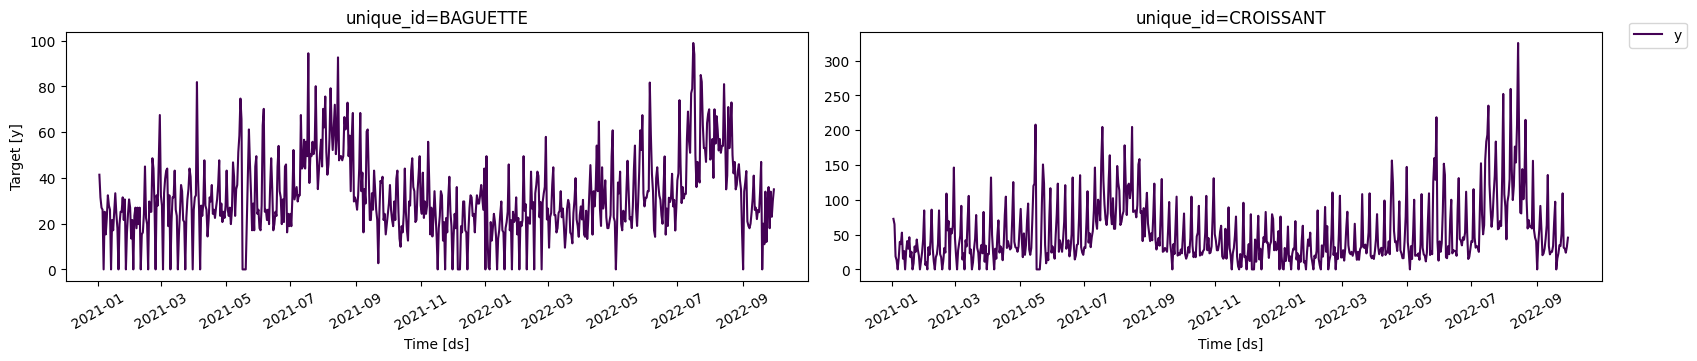

In [ ]:
plot_series(df=df , ids=["BAGUETTE", "CROISSANT"], palette="viridis")

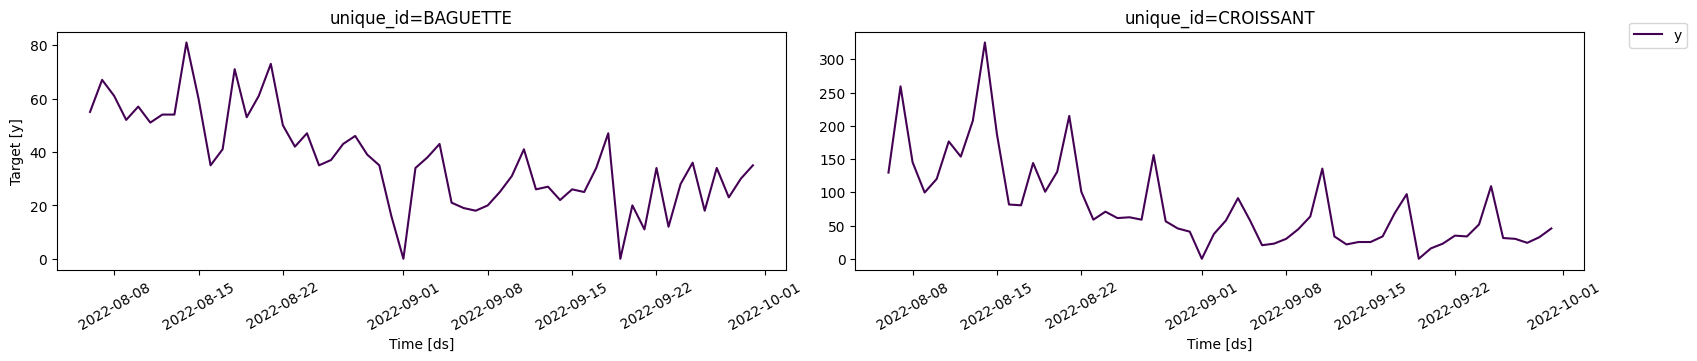

In [ ]:
plot_series(df=df , ids=["BAGUETTE", "CROISSANT"] , max_insample_length=56,palette="viridis")

In [ ]:
# Baseline model
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [ ]:
horizon =7
models =[
    Naive(),# last know value
    HistoricAverage(),# mean of the data
    WindowAverage(window_size=7),# steps to take accountable and callate
    SeasonalNaive(season_length=7) # predicts the value from the same season in the previous period (assuming a seasonality of 7)
]
sf=StatsForecast(models=models,freq='D')
sf.fit(df=df)
preds=sf.predict(h=horizon)

In [ ]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,2022-10-01,35.0,32.152904,29.142857,28.0
1,BAGUETTE,2022-10-02,35.0,32.152904,29.142857,36.0
2,BAGUETTE,2022-10-03,35.0,32.152904,29.142857,18.0
3,BAGUETTE,2022-10-04,35.0,32.152904,29.142857,34.0
4,BAGUETTE,2022-10-05,35.0,32.152904,29.142857,23.0


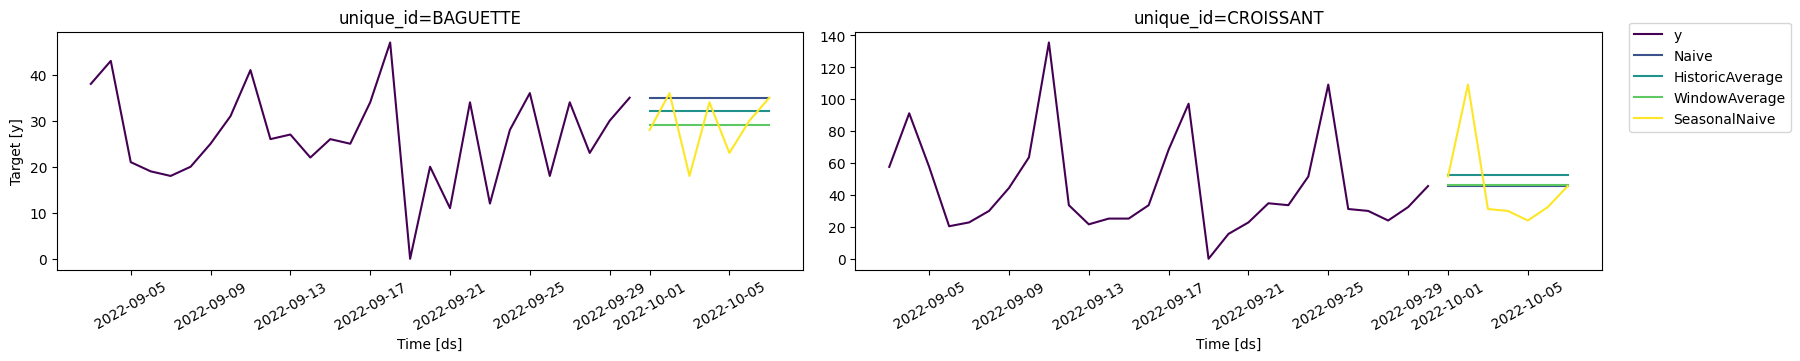

In [ ]:
plot_series(
    df =df,
    forecasts_df=preds,
    ids=["BAGUETTE", "CROISSANT"],
    palette="viridis",
    max_insample_length=28
)

In [ ]:
# evaltuing model
test=df.groupby("unique_id").tail(7)
train=df.drop(test.index).reset_index(drop=True)

In [ ]:
sf.fit(df=train)
preds=sf.predict(h=horizon)
eval_df=pd.merge(test ,preds ,"left", ['ds','unique_id'])

In [ ]:
evaluation=evaluate(
    eval_df,
    metrics=[mae]
)
evaluation.head()

,unique_id,metric,unit_price,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,28.142857,17.142857,5.455193,7.877551,12.571429
1,BAGUETTE APERO,mae,4.500000,0.000000,0.537572,0.642857,0.642857
2,BAGUETTE GRAINE,mae,2.800000,9.800000,4.612271,2.942857,0.200000
3,BANETTE,mae,32.035714,1.314286,5.421984,6.008163,7.885714
4,BANETTINE,mae,3.100000,0.400000,0.817800,0.714286,1.000000


In [ ]:
evaluation=evaluation.drop(['unique_id'],axis=1).groupby('metric').mean().reset_index()
evaluation.head()

,metric,unit_price,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,9.522716,6.411969,5.420735,5.273019,4.843179


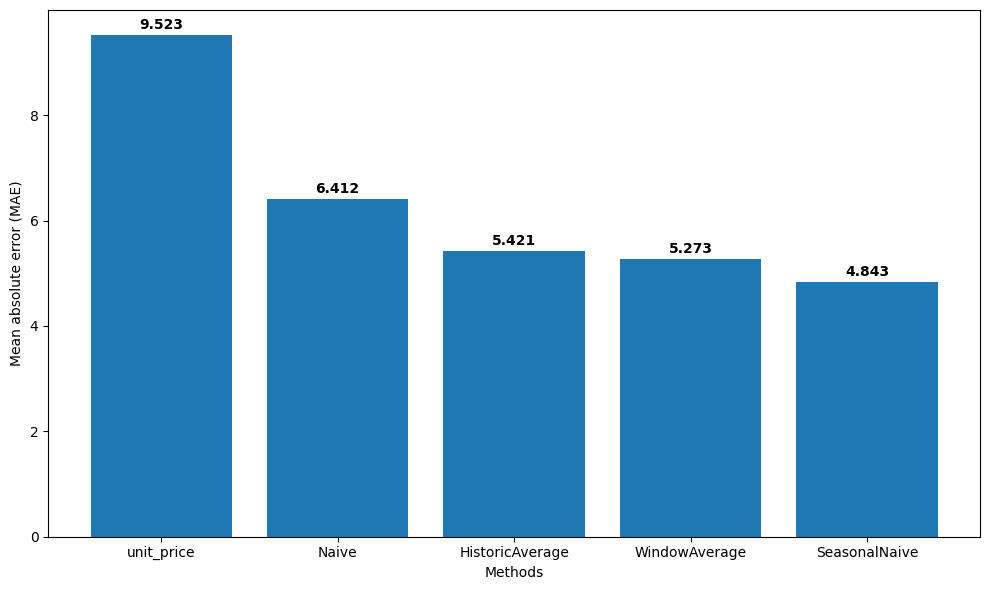

In [ ]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()


In [ ]:
# auto arima
from statsforecast.models import AutoARIMA

In [ ]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_train=train[train["unique_id"].isin(unique_ids)]
small_test=test[test["unique_id"].isin(unique_ids)]

models=[
    AutoARIMA(seasonal=False,alias="ARIMA"),
    AutoARIMA(season_length=7,alias="SARIMA_")
]
sf=StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_pred =sf.predict(h=horizon, X_df=small_test.drop(columns=['y']))
arima_eval_df=pd.merge(eval_df,arima_pred,"inner",['ds','unique_id'])
arima_eval=evaluate(
    arima_eval_df,
    metrics=[mae]
)
arima_eval.head()

,unique_id,metric,unit_price,Naive,HistoricAverage,WindowAverage,SeasonalNaive,ARIMA,SARIMA_
0,BAGUETTE,mae,28.142857,17.142857,5.455193,7.877551,12.571429,9.354470,7.363367
1,CROISSANT,mae,45.085714,17.485714,22.618934,18.244898,12.857143,14.780128,10.367773


In [ ]:
arima_eval=arima_eval.drop(['unique_id'],axis=1).groupby('metric').mean().reset_index()
arima_eval.head()

,metric,unit_price,Naive,HistoricAverage,WindowAverage,SeasonalNaive,ARIMA,SARIMA_
0,mae,36.614286,17.314286,14.037063,13.061224,12.714286,12.067299,8.86557


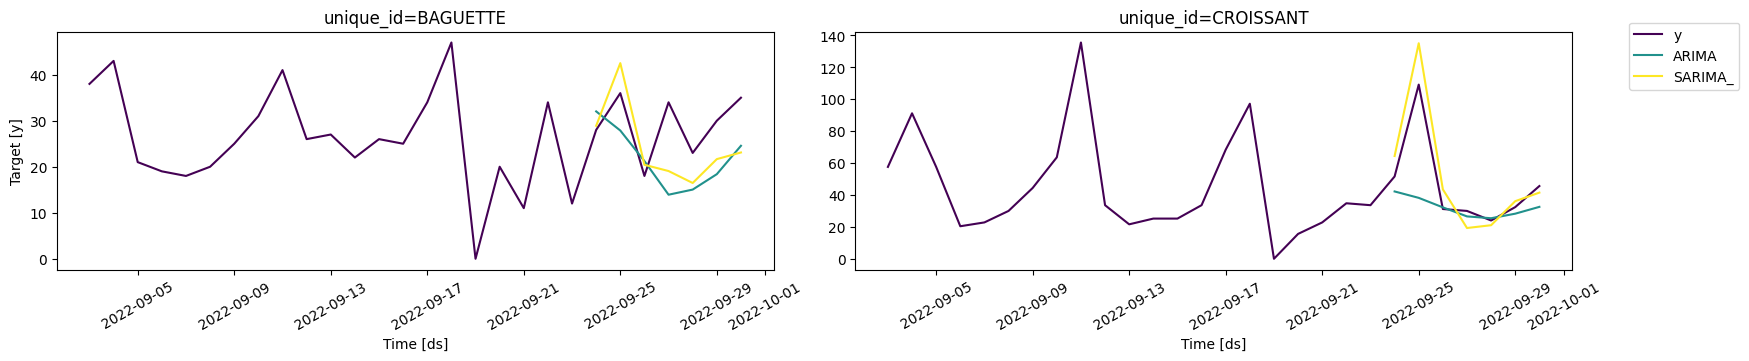

In [ ]:
plot_series(
    df=df,
    forecasts_df=arima_pred,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    palette="viridis")

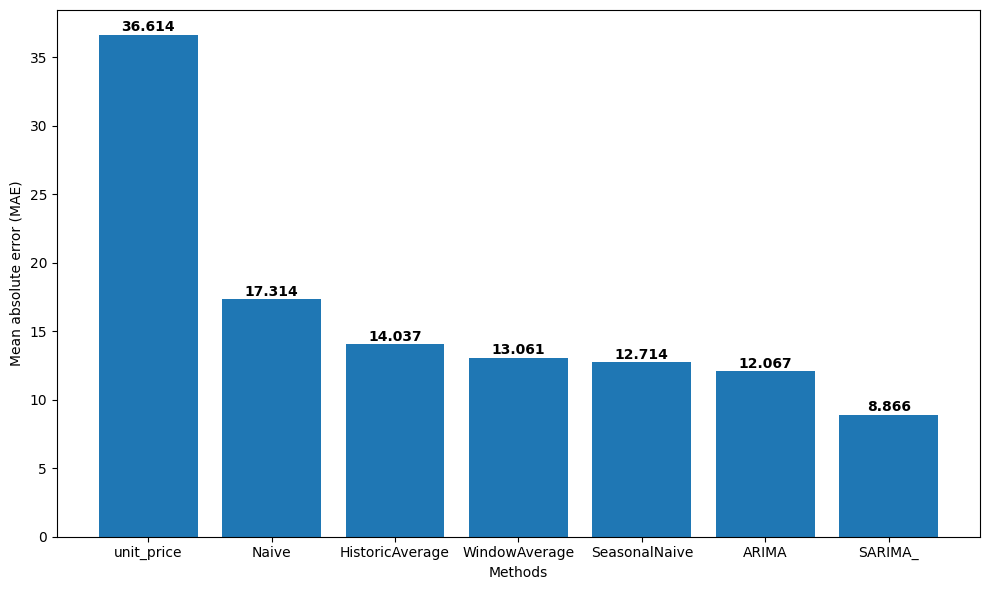

In [ ]:

methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

In [ ]:
# cross valiation
small_df=df[df['unique_id'].isin(unique_ids)]
models=[
     SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]
sf=StatsForecast(models=models,freq='D')
cv_df=sf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=True
    )
cv_df.head()


,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.362594,71.511188
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.357872,78.457622
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.199992,57.062223
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.644623,49.525279
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.770620,49.485229


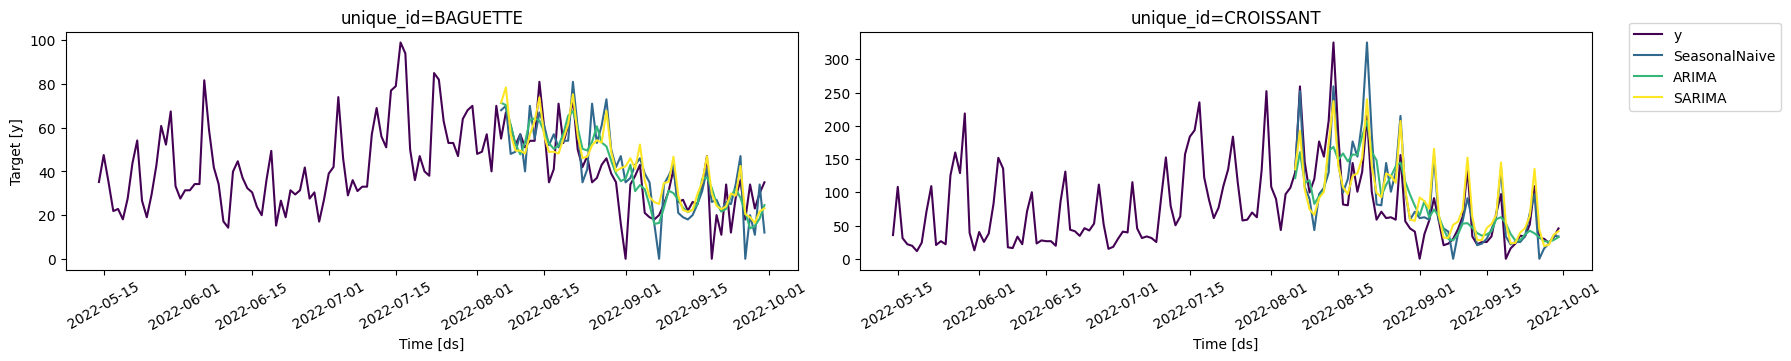

In [ ]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=140,
    palette="viridis")

In [ ]:
cv_eval=evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae]
)
cv_eval=cv_eval.drop(['unique_id'],axis=1).groupby('metric').mean().reset_index()
cv_eval.head()

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.767217,19.210052


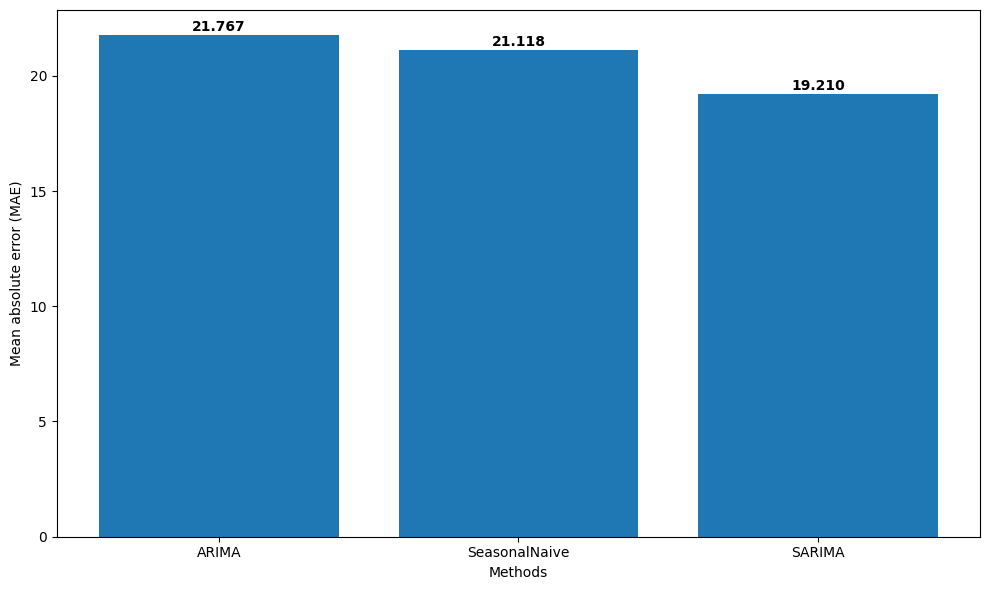

In [ ]:

methods = cv_eval.columns[1:].tolist()
values = cv_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

Using exogenous features


In [3]:
import pandas as pd

df=pd.read_csv("/content/daily_sales_french_bakery.csv",parse_dates=['ds'])
df=df.groupby("unique_id").filter(lambda x: len(x) > 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


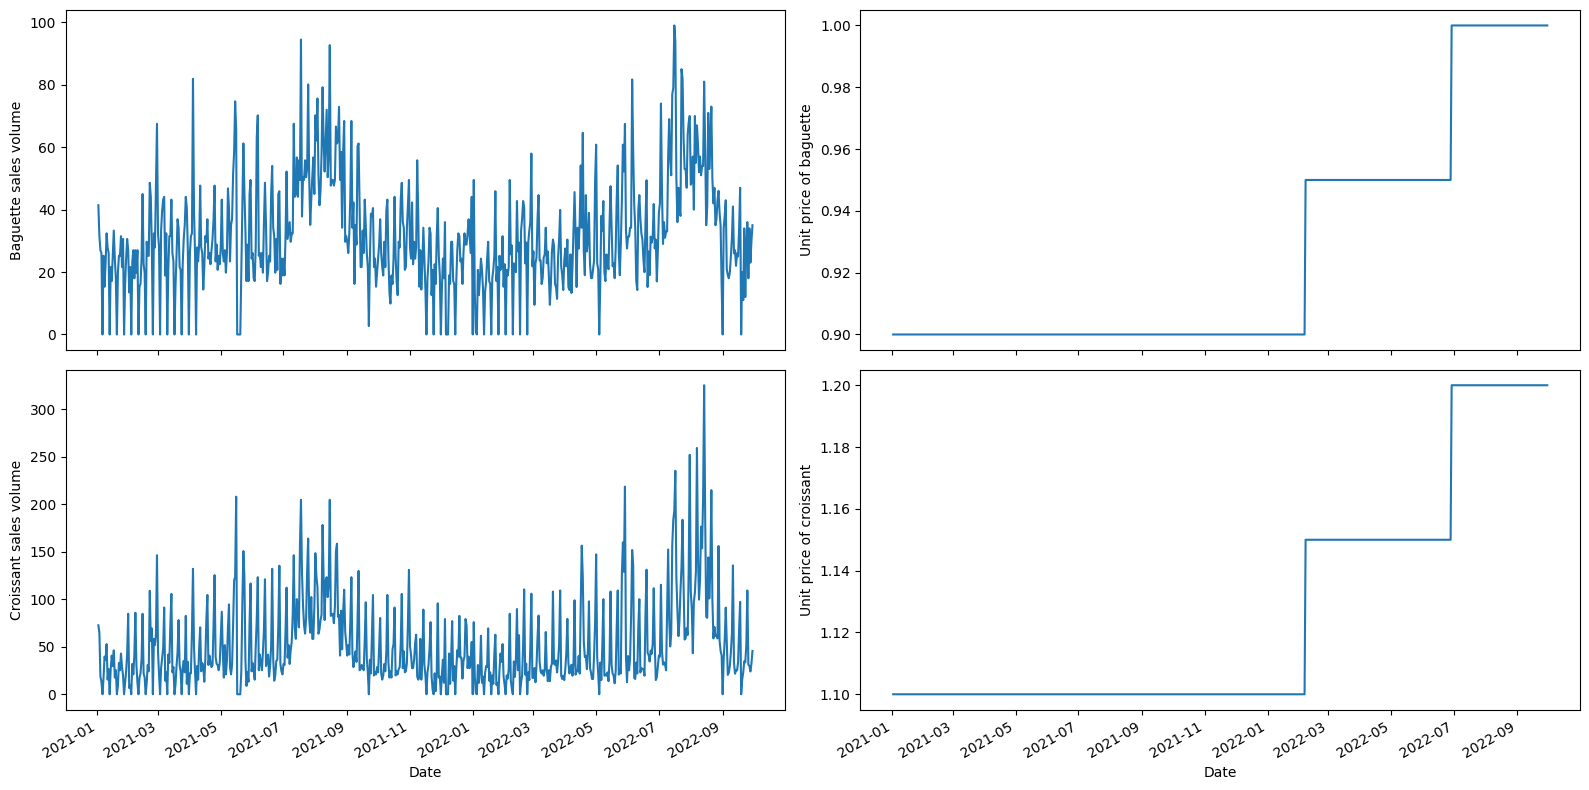

In [5]:
import matplotlib.pyplot as plt

baguette_plot_df = df[df["unique_id"] == "BAGUETTE"]
croissant_plot_df = df[df["unique_id"] == "CROISSANT"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

ax1.plot(baguette_plot_df["ds"], baguette_plot_df["y"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Baguette sales volume")

ax2.plot(baguette_plot_df["ds"], baguette_plot_df["unit_price"])
ax2.set_xlabel("Date")
ax2.set_ylabel("Unit price of baguette")

ax3.plot(croissant_plot_df["ds"], croissant_plot_df["y"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Croissant sales volume")

ax4.plot(croissant_plot_df["ds"], croissant_plot_df["unit_price"])
ax4.set_xlabel("Date")
ax4.set_ylabel("Unit price of croissant")

fig.autofmt_xdate()
plt.tight_layout()

In [6]:
unique_ids=["BAGUETTE", "CROISSANT"]
small_df=df[df['unique_id'].isin(unique_ids)]
test=small_df.groupby("unique_id").tail(7)
train=small_df.drop(test.index).reset_index(drop=True)

In [8]:
futr_exog_df=test.drop(["y"],axis=1)
futr_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [16]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

horizon = 7
models=[

    AutoARIMA(season_length=7,alias="SARIMA_exog")
]
sf=StatsForecast(models=models,freq='D')
sf.fit(df=train)
# prediciting with exogenous features

arima_exog_preds=sf.predict(h=horizon,X_df=futr_exog_df)

models={
    AutoARIMA(season_length=7,alias="SARIMA_")
}
sf = StatsForecast(models=models,freq='D')
sf.fit(df=train)
arima_preds=sf.predict(h=horizon, X_df=futr_exog_df)

In [20]:
test_df=pd.merge(test, arima_preds, on = ['ds', 'unique_id'], how = 'left')\
.merge(arima_exog_preds, on = ['ds', 'unique_id'], how = 'left')
test_df

,unique_id,ds,y,unit_price,SARIMA_,SARIMA_exog
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,28.898898
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,42.513264
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,20.423976
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,19.066264
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,16.468885
5,BAGUETTE,2022-09-29,30.0,1.0,21.656726,21.656726
6,BAGUETTE,2022-09-30,35.0,1.0,23.101235,23.101235
7,CROISSANT,2022-09-24,51.6,1.2,64.424926,64.424926
8,CROISSANT,2022-09-25,109.2,1.2,135.124207,135.124207
9,CROISSANT,2022-09-26,31.2,1.2,43.526109,43.526109


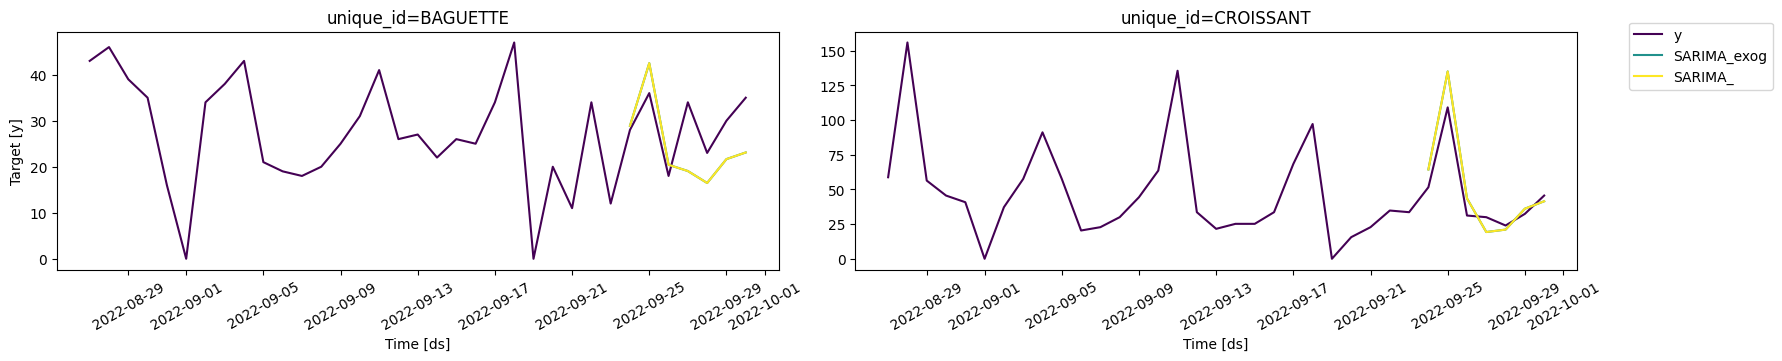

In [22]:

plot_series(
    df=train,
    forecasts_df=test_df,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    models=["SARIMA_exog", "SARIMA_"],
    palette="viridis"
)

In [23]:
models={
    AutoARIMA(season_length=7,alias="SARIMA_exog")
}
sf = StatsForecast(models=models,freq='D')

# cross validation
cv_exog_df=sf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=True,

)
cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683


In [24]:
cv_exog_eval=evaluate(
    cv_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae]
)
cv_exog_eval=cv_exog_eval.drop(['unique_id'],axis=1).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,19.211687


In [25]:

from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [27]:
Features=[
    partial(fourier,season_length=7, k=2),
    partial(time_features, features=["day", "week", "month"])
]
small_exof_df,futr_exog_df=pipeline(
    df=small_df,
    features=Features,
    freq='D',
    h=horizon
)

In [28]:
small_exof_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [29]:
futr_exog_df.head()

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10


In [31]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_time_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_time_exog_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_exof_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_time_exog_eval = cv_time_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_time_exog
0,mae,19.721581


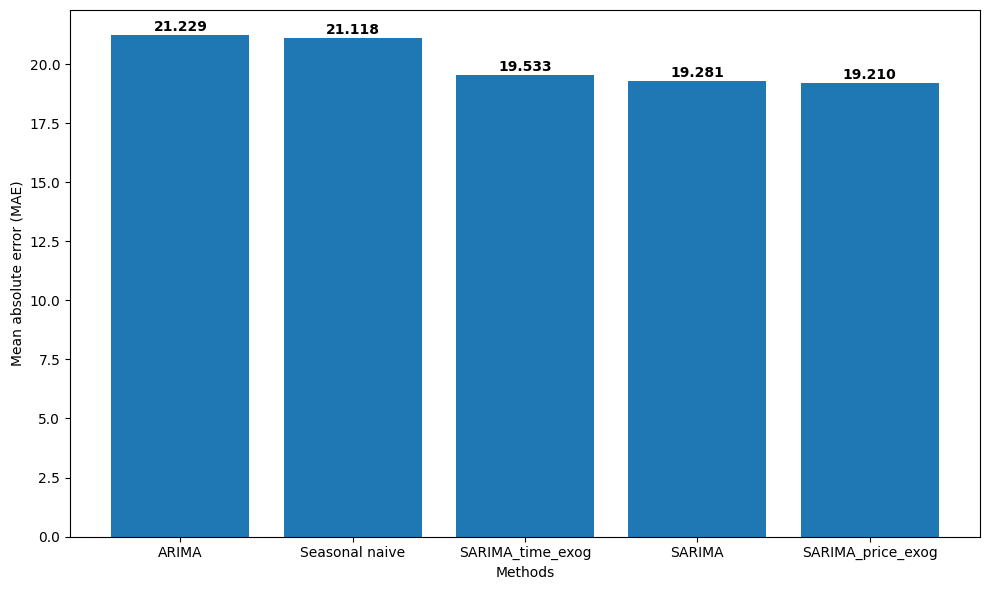

In [32]:
""
methods = ["ARIMA", "Seasonal naive", "SARIMA", "SARIMA_price_exog", "SARIMA_time_exog"]
values = [21.229, 21.118, 19.281, 19.210, 19.533]

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()


In [33]:
# predcitin intervals

unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [34]:

train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [35]:
models=[
    AutoARIMA(season_length=7)
]
sf=StatsForecast(models=models,freq='D')
sf.fit(df=train)
prob_preds=sf.predict(h=horizon,X_df=test.drop(['y'], axis=1), level=[80, 90])
prob_preds.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90
0,BAGUETTE,2022-09-24,28.898898,11.882653,15.641064,42.156732,45.915144
1,BAGUETTE,2022-09-25,42.513264,24.306554,28.327906,56.698621,60.719973
2,BAGUETTE,2022-09-26,20.423976,1.772051,5.891738,34.956214,39.075902
3,BAGUETTE,2022-09-27,19.066264,0.102217,4.290843,33.841685,38.030311
4,BAGUETTE,2022-09-28,16.468885,-2.763838,1.484132,31.453637,35.701607


In [36]:
test_df=pd.merge(test,prob_preds,on=['ds','unique_id'],how='left')
test_df.head()

,unique_id,ds,y,unit_price,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,11.882653,15.641064,42.156732,45.915144
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,24.306554,28.327906,56.698621,60.719973
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,1.772051,5.891738,34.956214,39.075902
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,0.102217,4.290843,33.841685,38.030311
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,-2.763838,1.484132,31.453637,35.701607


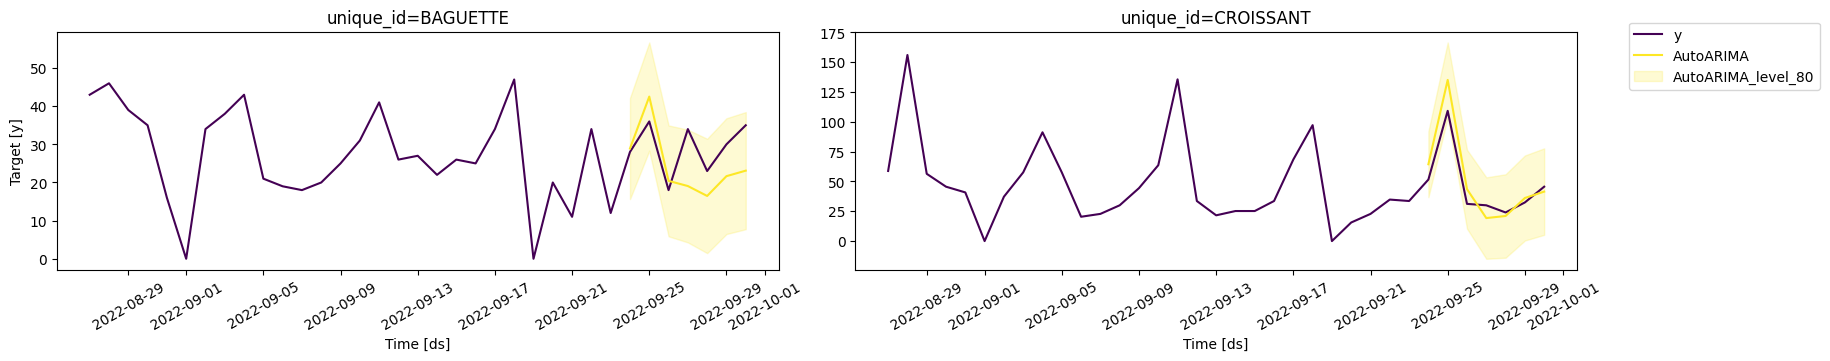

In [37]:

plot_series(
    df=train,
    forecasts_df=test_df,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    models=["AutoARIMA"],
    level=[80],
    palette="viridis"
)

In [38]:

models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
cv_prob_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True,
    level=[80],
)

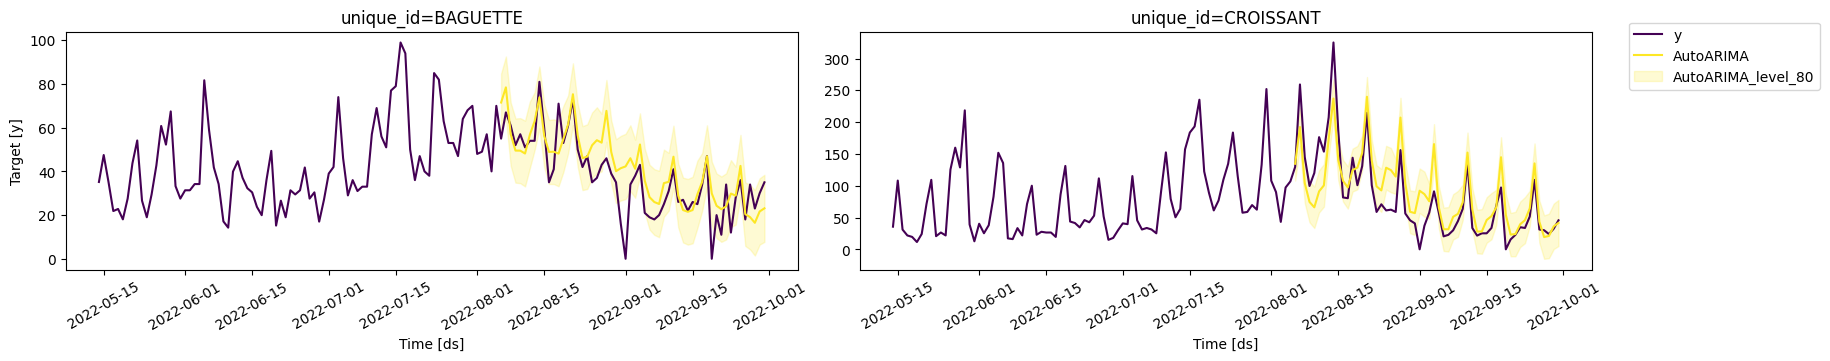

In [39]:

plot_series(
    df=small_df,
    forecasts_df=cv_prob_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE", "CROISSANT"],
    models=["AutoARIMA"],
    max_insample_length=140,
    level=[80],
    palette="viridis"
)

In [44]:
from statsforecast.models import AutoARIMA, SeasonalNaive
from statsforecast import StatsForecast

horizon = 7
models=[
    AutoARIMA(season_length=7,alias="SARIMA_EXOG"),
    SeasonalNaive(season_length=7)
]
sf = StatsForecast(models=models,freq='D')
final_cv_df=sf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=True,
    level=[80]
)

In [45]:
final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_EXOG,SARIMA_EXOG-lo-80,SARIMA_EXOG-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528,58.279213,84.743843,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054,64.354114,92.561995,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745,42.622201,71.503290,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901,34.847356,64.204446,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683,34.606853,64.364512,57.0,39.158042,74.841958


In [46]:

temp_test = small_df.groupby("unique_id").tail(7*8)
temp_train = small_df.drop(temp_test.index).reset_index(drop=True)

In [48]:
models = ["SARIMA_EXOG", "SeasonalNaive"]
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape,
    partial(mase, seasonality=7),
    scaled_crps
]

final_eval = evaluate(
    final_cv_df.drop(["ds", "cutoff"], axis=1),
    metrics=metrics,
    models=models,
    train_df=temp_train,
    level=[80]
)
final_eval = final_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
final_eval

,metric,SARIMA_EXOG,SeasonalNaive
0,mae,19.211687,21.117857
1,mape,0.328615,0.376819
2,mase,1.181499,1.328592
3,mse,792.788111,970.417143
4,rmse,24.979598,27.875413
5,scaled_crps,0.153636,0.166451
6,smape,0.168241,0.211317


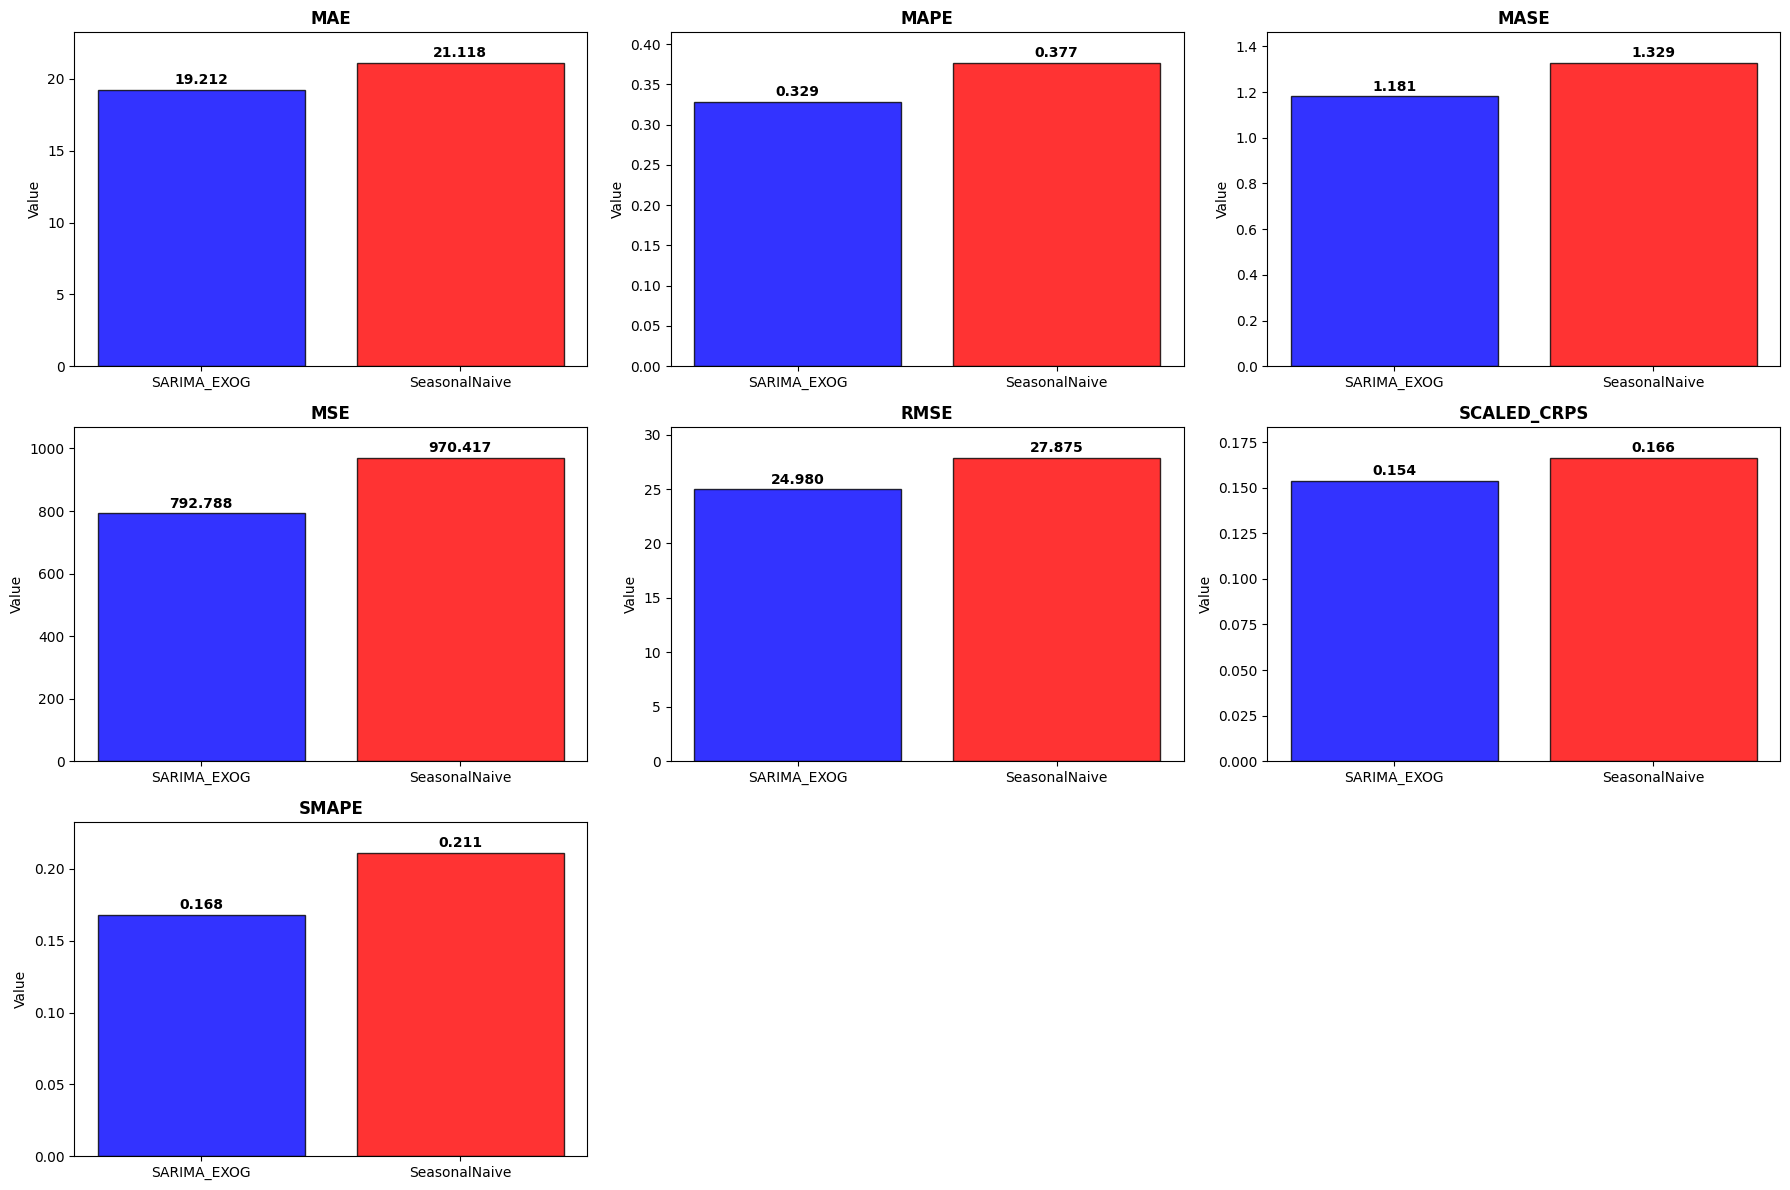

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

axes_flat = axes.flatten()

models = ['SARIMA_EXOG', 'SeasonalNaive']
x_pos = [0, 1]
colors = ['blue', 'red']

for i, row in final_eval.iterrows():
    ax = axes_flat[i]

    model_values = [row['SARIMA_EXOG'], row['SeasonalNaive']]

    bars = ax.bar(x_pos, model_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

    for j, (bar, value) in enumerate(zip(bars, model_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax.set_title(row['metric'].upper(), fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, ha='center')
    ax.set_ylabel('Value')
    max_value = max(model_values)
    ax.set_ylim(0, max_value * 1.1)

fig.delaxes(axes_flat[7])
fig.delaxes(axes_flat[8])

plt.tight_layout()
plt.show()